## Importing standard libraries 

In [3]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'E:\gitlab\custom-script\script')
from ursar import clustering

%reload_ext autoreload

## Reading data and preprocessing

In [5]:
df = pd.read_excel(f'E:\gitlab\machine-learning\dataset\Online Retail.xlsx')

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.shape

(541909, 8)

Removing duplicate entries.

In [8]:
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
df.drop_duplicates(inplace = True)

Duplicate entries: 5268
1% rows are duplicate.


Checking the total number of products, transactions and customers.

In [9]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Checking country wise distribution of transactions.

In [10]:
temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)

In [11]:
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)

Text(0, 0.5, '%Orders')

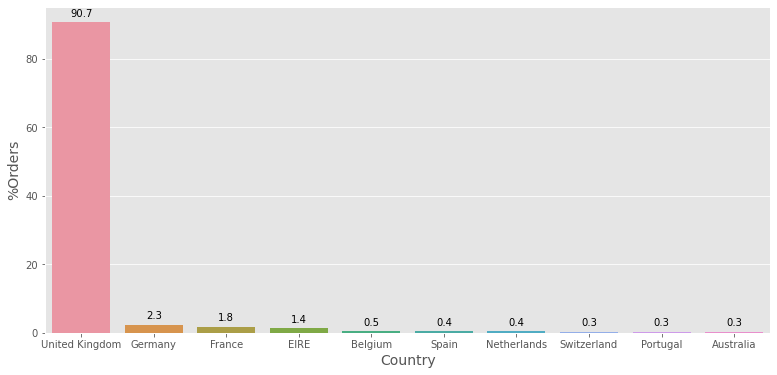

In [12]:
plt.figure(figsize=(13,6))
splot=sns.barplot(x="Country",y="%Orders",data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)

Removing cancelled orders from the data.

In [13]:
invoices = df['InvoiceNo']

In [14]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)

In [15]:
x = x.astype(int)

In [16]:
x.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [17]:
df['order_canceled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [18]:
df['order_canceled'].value_counts()

0    527390
1      9251
Name: order_canceled, dtype: int64

In [19]:
n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 9251/536641 (1.72%) 


In [20]:
df = df.loc[df['order_canceled'] == 0,:]

In [21]:
df.reset_index(drop=True,inplace=True)

Checking if we have negative quantities against any InvoiceNo.

In [22]:
df.loc[df['Quantity'] < 0,:]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.

In [23]:
df = df[df['CustomerID'].notna()]

In [24]:
df.reset_index(drop=True,inplace=True)

In [25]:
df_uk = df[df.Country == 'United Kingdom']

In [26]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [27]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   InvoiceNo       349227 non-null  object        
 1   StockCode       349227 non-null  object        
 2   Description     349227 non-null  object        
 3   Quantity        349227 non-null  int64         
 4   InvoiceDate     349227 non-null  datetime64[ns]
 5   UnitPrice       349227 non-null  float64       
 6   CustomerID      349227 non-null  float64       
 7   Country         349227 non-null  object        
 8   order_canceled  349227 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(4)
memory usage: 25.3+ MB


In [28]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),    
               'transactions': len(df['InvoiceNo'].value_counts()),
               'customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


## Cohort Analysis 

What is Cohort Analysis?

A cohort is a set of users who share similar characteristics over time. Cohort analysis groups the users into mutually exclusive groups and their behaviour is measured over time.

It can provide information about product and customer lifecycle.

There are three types of cohort analysis: 
1. Time cohorts: It groups customers by their purchase behaviour over time.
2. Behaviour cohorts: It groups customers by the product or service they signed up for.
3. Size cohorts: Refers to various sizes of customers who purchase company's products or services. This categorization can be based on the amount of spending in some period of time.

Understanding the needs of various cohorts can help a company design custom-made services or products for particular segments.

In the following analysis, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [29]:
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]

In [30]:
# Checking for nulls in the data.
cohort_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [31]:
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x:x.date())

Cohort analysis groups


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


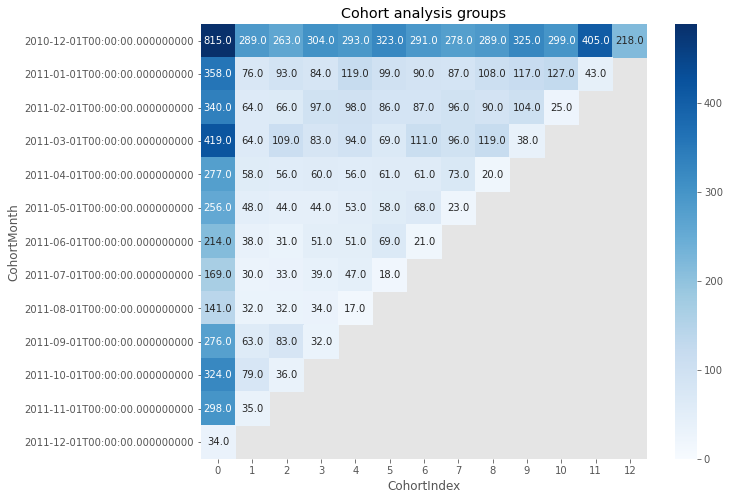

retention rate


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,35.5,32.3,37.3,36.0,39.6,35.7,34.1,35.5,39.9,36.7,49.7,26.7
2011-01-01,100.0,21.2,26.0,23.5,33.2,27.7,25.1,24.3,30.2,32.7,35.5,12.0,NaN
2011-02-01,100.0,18.8,19.4,28.5,28.8,25.3,25.6,28.2,26.5,30.6,7.4,NaN,NaN
2011-03-01,100.0,15.3,26.0,19.8,22.4,16.5,26.5,22.9,28.4,9.1,NaN,NaN,NaN
2011-04-01,100.0,20.9,20.2,21.7,20.2,22.0,22.0,26.4,7.2,NaN,NaN,NaN,NaN
2011-05-01,100.0,18.8,17.2,17.2,20.7,22.7,26.6,9.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.8,14.5,23.8,23.8,32.2,9.8,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,17.8,19.5,23.1,27.8,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,22.7,22.7,24.1,12.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


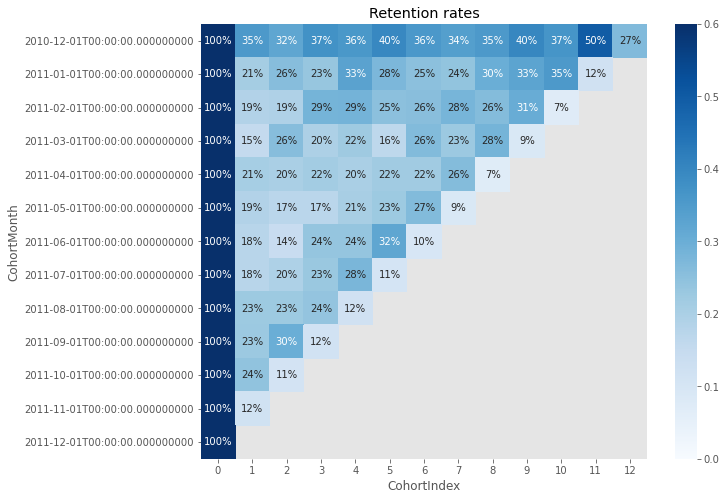

average Quantity for each cohort


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.36,12.86,13.93,13.87,13.34,13.29,14.27,13.77,16.14,16.12,16.67,12.45,14.46
2011-01-01,18.08,9.63,9.44,15.10,10.09,10.89,13.55,10.81,10.76,8.70,8.59,10.02,NaN
2011-02-01,11.00,14.05,15.95,12.12,12.32,11.93,13.87,13.72,11.00,12.54,13.82,NaN,NaN
2011-03-01,9.70,11.43,13.31,10.09,13.53,12.84,13.11,14.06,11.20,9.73,NaN,NaN,NaN
2011-04-01,10.07,10.16,9.72,11.94,11.86,8.26,9.87,9.36,7.48,NaN,NaN,NaN,NaN
2011-05-01,10.66,9.39,14.84,12.80,11.05,8.31,10.82,126.91,NaN,NaN,NaN,NaN,NaN
2011-06-01,9.55,14.79,11.98,12.74,9.82,8.89,9.35,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,10.15,14.98,6.57,8.11,5.78,6.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.39,6.03,5.03,5.91,6.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


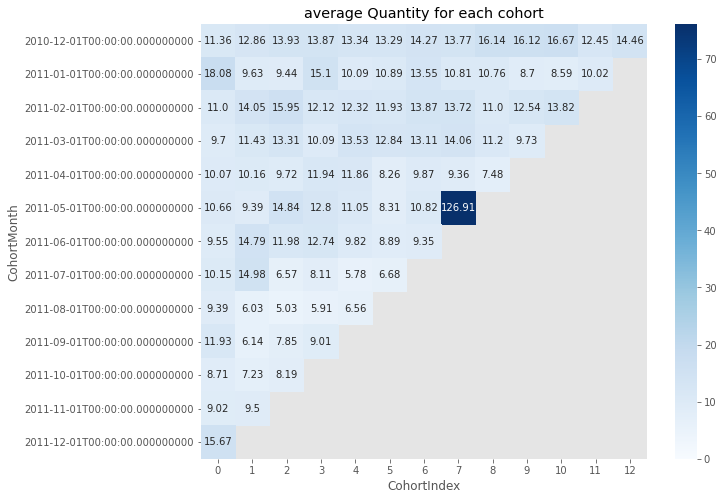

(CohortIndex     0      1      2      3      4      5      6      7      8   \
 CohortMonth                                                                  
 2010-12-01   815.0  289.0  263.0  304.0  293.0  323.0  291.0  278.0  289.0   
 2011-01-01   358.0   76.0   93.0   84.0  119.0   99.0   90.0   87.0  108.0   
 2011-02-01   340.0   64.0   66.0   97.0   98.0   86.0   87.0   96.0   90.0   
 2011-03-01   419.0   64.0  109.0   83.0   94.0   69.0  111.0   96.0  119.0   
 2011-04-01   277.0   58.0   56.0   60.0   56.0   61.0   61.0   73.0   20.0   
 2011-05-01   256.0   48.0   44.0   44.0   53.0   58.0   68.0   23.0    NaN   
 2011-06-01   214.0   38.0   31.0   51.0   51.0   69.0   21.0    NaN    NaN   
 2011-07-01   169.0   30.0   33.0   39.0   47.0   18.0    NaN    NaN    NaN   
 2011-08-01   141.0   32.0   32.0   34.0   17.0    NaN    NaN    NaN    NaN   
 2011-09-01   276.0   63.0   83.0   32.0    NaN    NaN    NaN    NaN    NaN   
 2011-10-01   324.0   79.0   36.0    NaN    NaN    N

In [35]:
clustering.cs_cohort(cohort_data,'InvoiceDate','CustomerID','Quantity')

# RFM analysis

In [36]:
cohort_data['TotalSum'] = cohort_data['Quantity']*cohort_data['UnitPrice']
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34


Let us check the distribution of the TotalSum column to understand customer spending.

<AxesSubplot:>

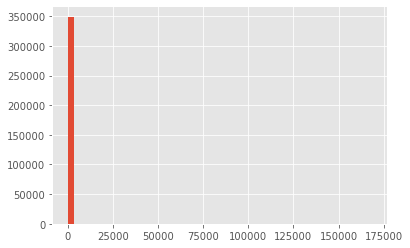

In [37]:
cohort_data.TotalSum.hist(bins=50)

In [38]:
cohort_data[['TotalSum']].describe()

,TotalSum
count,349227.000000
mean,20.860428
std,328.406035
min,0.000000
25%,4.200000
50%,10.200000
75%,17.850000
max,168469.600000


In [39]:
cohort_data[cohort_data['TotalSum']> 17.850000].sort_values('TotalSum',ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
392266,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011-12-01,2011-05-01,7,168469.60
36527,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-01,2011-01-01,0,77183.60
153601,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,2011-06-01,2011-06-01,0,38970.00
116879,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,2011-05-01,2010-12-01,5,8142.75
246062,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,2011-09-01,2010-12-01,9,7144.72
...,...,...,...,...,...,...,...,...,...,...,...,...
65572,545081,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 10:35:00,1.49,16057.0,United Kingdom,2011-02-01,2011-02-01,0,17.88
89499,547921,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-03-28 13:28:00,1.49,14766.0,United Kingdom,2011-03-01,2010-12-01,3,17.88
65822,545150,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 12:27:00,1.49,14227.0,United Kingdom,2011-02-01,2011-02-01,0,17.88
31685,540691,21673,WHITE SPOT BLUE CERAMIC DRAWER KNOB,12,2011-01-11 08:50:00,1.49,17450.0,United Kingdom,2011-01-01,2010-12-01,1,17.88


Let us check the max date and take data till a year behind the max date.

In [40]:
from dateutil.relativedelta import relativedelta
start_date = all_dates.max()-relativedelta(months=12,days=-1)
print('Start date: {}'.format(start_date))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-10
End date: 2011-12-09


In [41]:
data_rfm = cohort_data[cohort_data['InvoiceDate'] >= pd.to_datetime(start_date)]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,2010-12-01,2010-12-01,0,15.0
1,538172,79321,CHILLI LIGHTS,8,2010-12-10 09:33:00,4.95,15805.0,United Kingdom,2010-12-01,2010-12-01,0,39.6
2,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805.0,United Kingdom,2010-12-01,2010-12-01,0,30.6
3,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805.0,United Kingdom,2010-12-01,2010-12-01,0,35.4
4,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805.0,United Kingdom,2010-12-01,2010-12-01,0,13.2


In [42]:
snapshot_date = max(data_rfm.InvoiceDate) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2011-12-10


RFM origin data


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,3,113,5
1,12747.0,2,96,3837.45,3,2,3,323,8
2,12748.0,1,4055,31081.74,3,3,3,333,9
3,12749.0,4,199,4090.88,3,3,3,333,9
4,12820.0,3,59,942.34,3,2,3,323,8
...,...,...,...,...,...,...,...,...,...
3850,18280.0,278,10,180.60,1,1,3,113,5
3851,18281.0,181,7,80.82,1,1,2,112,4
3852,18282.0,8,12,178.05,3,1,3,313,7
3853,18283.0,4,721,2045.53,3,3,3,333,9


RFM agg data


Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3           273.5       1.0      8.2     2
4           250.4       4.9     81.9    89
5           206.3       7.3    696.9   338
6           165.6      22.6    467.4   791
7            60.4      49.5   1084.8  1540
8            24.7     150.9   2662.4   766
9             5.0     375.6   8161.1   329

RFM general segment data


Recency Frequency Monetary      
                   mean      mean     mean count
General_Segment                                 
Low               250.9       4.9     80.3    91
Middle             91.0      61.8   1256.3  3435
Top                 5.0     375.6   8161.1   329

describe RFM data


,Recency,Frequency,Monetary
count,3855.00,3855.00,3855.00
mean,87.43,87.21,1817.79
std,93.43,209.41,7190.04
min,1.00,1.00,0.00
25%,17.00,16.00,291.68
50%,50.00,40.00,638.06
75%,134.00,96.00,1545.52
max,365.00,7491.00,231822.69


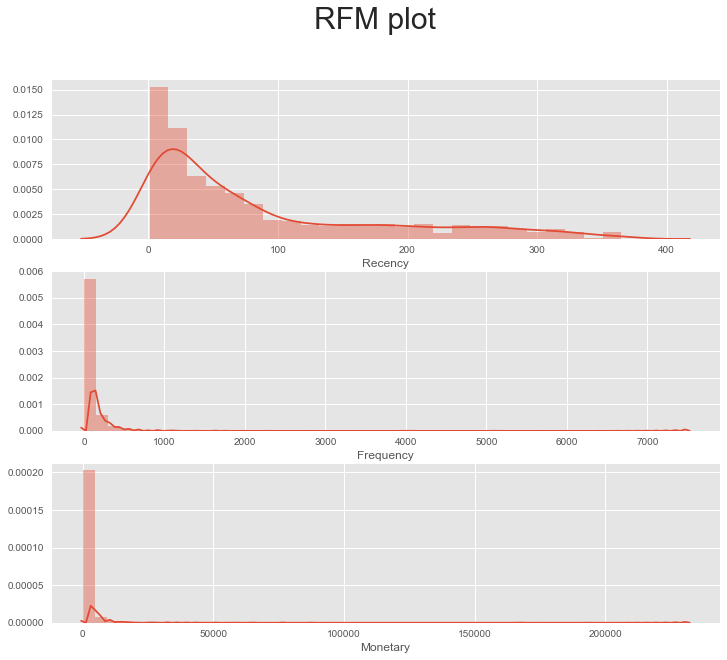

RFM with removal 0 value data


,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_segment,RFM_Score,General_Segment
0,12346.0,326,1,77183.60,1,1,3,113,5,Middle
1,12747.0,2,96,3837.45,3,2,3,323,8,Middle
2,12748.0,1,4055,31081.74,3,3,3,333,9,Top
3,12749.0,4,199,4090.88,3,3,3,333,9,Top
4,12820.0,3,59,942.34,3,2,3,323,8,Middle
...,...,...,...,...,...,...,...,...,...,...
3850,18280.0,278,10,180.60,1,1,3,113,5,Middle
3851,18281.0,181,7,80.82,1,1,2,112,4,Low
3852,18282.0,8,12,178.05,3,1,3,313,7,Middle
3853,18283.0,4,721,2045.53,3,3,3,333,9,Top


RFM with removal 0 value data and transform


,Recency,Frequency,Monetary
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.307706,10.344376
3,1.386294,5.293305,8.316515
4,1.098612,4.077537,6.848366
...,...,...,...
3850,5.627621,2.302585,5.196285
3851,5.198497,1.945910,4.392224
3852,2.079442,2.484907,5.182064
3853,1.386294,6.580639,7.623412


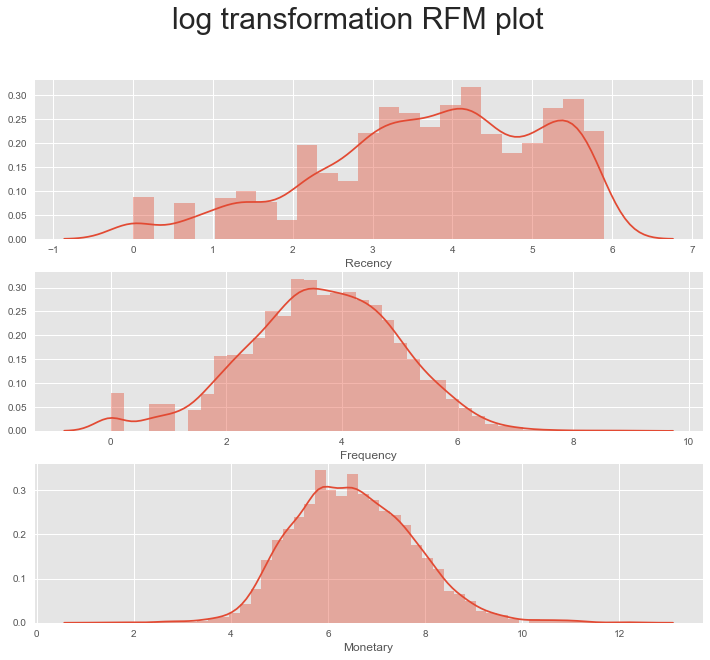

In [129]:
zz = [.2, .25, .3, .35, .4, .5, .6, .7, .8, .9]
rfm_1,rfm_2,rfm_3,rfm_4,rfm_5 = clustering.cs_rfm(data_rfm,'InvoiceDate','CustomerID','InvoiceNo',"Quantity","UnitPrice",zz)

# Preprocessing data for Clustering

In the next section, we are going to prepare the data for Kmeans clustering on RFM Score data. To do this, we need to preprocess the data so that it can meet the key assumptions of Kmeans algorithm, which are:

1. The varaiables should be distributed symmetrically
2. Variables should have similar average values
3. Variables should have similar standard deviation values

As we can see from the above plots, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness, we can try the following transformations:

1. log transformations
2. Box-Cox transformations
3. Cube root transformations

The log transformation cannot be used for negative values. One common practice one can use here is to add a constant value to get a positive value and this is generally taken as the absolute of the least negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset. 

In [109]:
rfm_5

,Recency,Frequency,Monetary
0,8.220134,0.000000,11.253942
1,8.129175,4.564348,8.252563
2,8.128585,8.307706,10.344376
3,8.129470,5.293305,8.316515
4,8.129470,4.077537,6.848366
...,...,...,...
3849,8.207129,2.302585,5.196285
3850,8.180321,1.945910,4.392224
3851,8.130648,2.484907,5.182064
3852,8.129470,6.580639,7.623412


## Clustering with K-means algorithm 

In this section, we will build multiple clusters upon our RFM data (data_norm) and will try to find out the optimal number of clusters in our data using the elbow method.

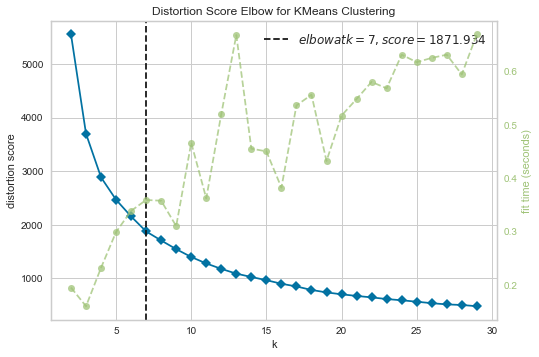

In [80]:
clustering.scoring_cluster(rfm_5,'elbow',30)


Score for number of cluster(s) 2: -5552.872459996935
Silhouette score for number of cluster(s) 2: 0.47705294290233335
Davies Bouldin score for number of cluster(s) 2: 0.7372468923258736

Score for number of cluster(s) 3: -3697.1015260599647
Silhouette score for number of cluster(s) 3: 0.4069275527473691
Davies Bouldin score for number of cluster(s) 3: 0.7967146920687886

Score for number of cluster(s) 4: -2881.5868371276315
Silhouette score for number of cluster(s) 4: 0.36911345812215607
Davies Bouldin score for number of cluster(s) 4: 0.8536584807161502

Score for number of cluster(s) 5: -2463.949569893104
Silhouette score for number of cluster(s) 5: 0.33940538316888147
Davies Bouldin score for number of cluster(s) 5: 0.9168797623094613

Score for number of cluster(s) 6: -2151.638226274419
Silhouette score for number of cluster(s) 6: 0.3549549582163383
Davies Bouldin score for number of cluster(s) 6: 0.8660707409953701

Score for number of cluster(s) 7: -1872.127926242289
Silhouette 

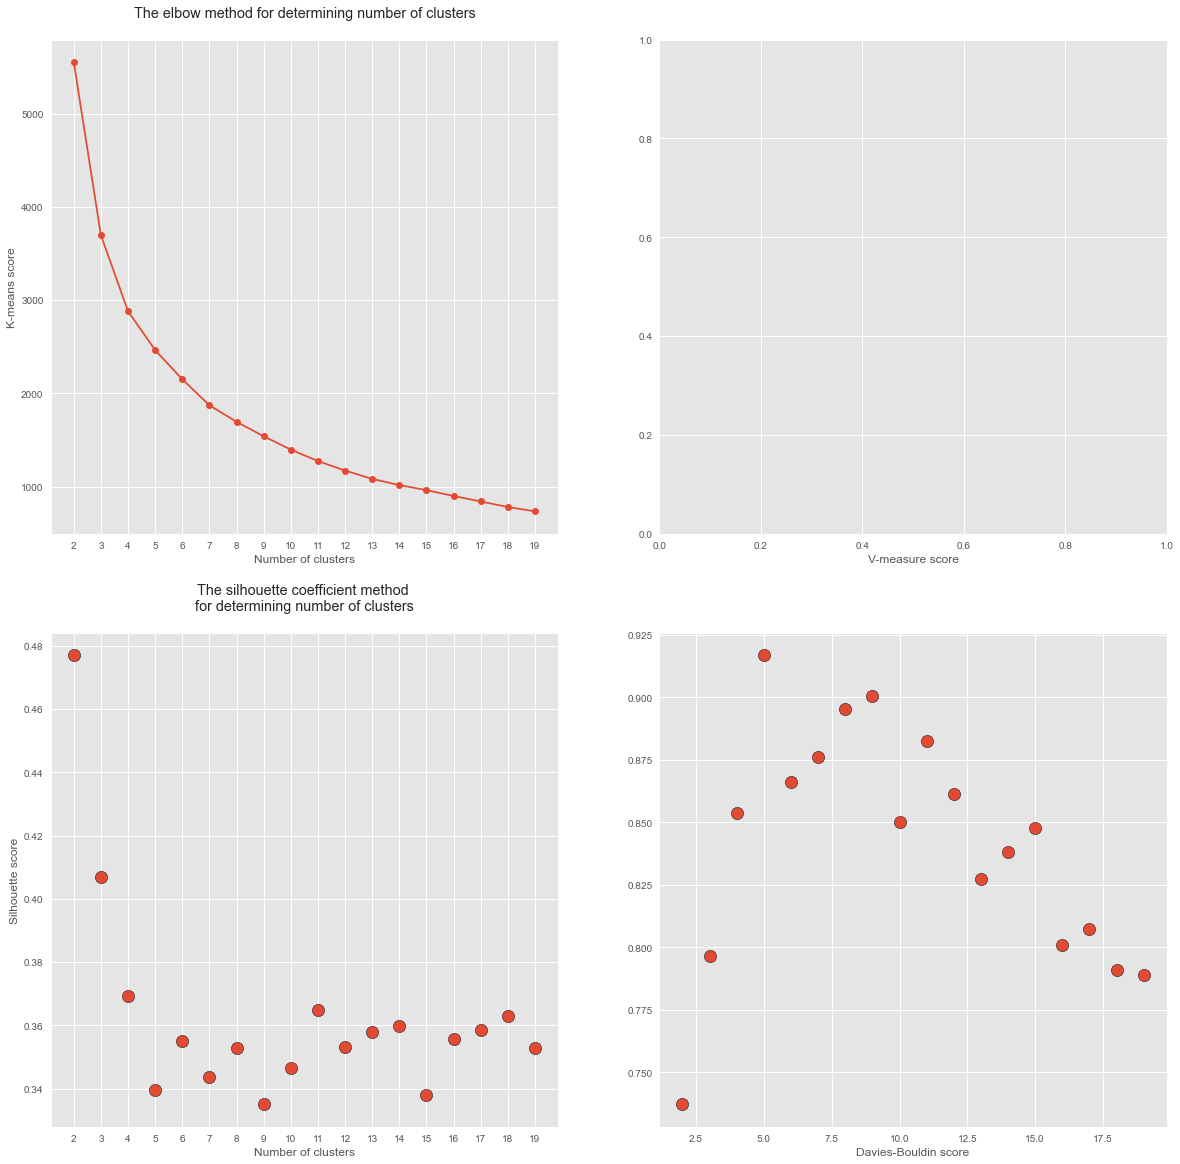

In [89]:
clustering.clus_kmean(rfm_4,20)

In [91]:
from sklearn.cluster import KMeans

In [116]:
kmeans = KMeans(n_clusters=7, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(rfm_5)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [159]:
rfm_5

,Recency,Frequency,Monetary
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.307706,10.344376
3,1.386294,5.293305,8.316515
4,1.098612,4.077537,6.848366
...,...,...,...
3850,5.627621,2.302585,5.196285
3851,5.198497,1.945910,4.392224
3852,2.079442,2.484907,5.182064
3853,1.386294,6.580639,7.623412


In [158]:
data_k,summary_k = clustering.cluster_labels(rfm_4,rfm_5,'CustomerID',cluster_labels)

,CustomerID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_segment,RFM_Score,General_Segment,Cluster
0,12346.0,326,1,77183.60,1,1,3,113,5,Middle,5
1,12747.0,2,96,3837.45,3,2,3,323,8,Middle,0
2,12748.0,1,4055,31081.74,3,3,3,333,9,Top,3
3,12749.0,4,199,4090.88,3,3,3,333,9,Top,0
4,12820.0,3,59,942.34,3,2,3,323,8,Middle,2
...,...,...,...,...,...,...,...,...,...,...,...
3850,18280.0,278,10,180.60,1,1,3,113,5,Middle,1
3851,18281.0,181,7,80.82,1,1,2,112,4,Low,1
3852,18282.0,8,12,178.05,3,1,3,313,7,Middle,1
3853,18283.0,4,721,2045.53,3,3,3,333,9,Top,3


Calculate average RFM values and size for each cluster


Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0          38.0     151.0   2391.0   725
1         148.0      11.0    194.0   643
2          66.0      64.0    950.0   929
3          14.0     463.0  11903.0   280
4         114.0      31.0    374.0   924
5          94.0      11.0   3193.0   177
6         154.0       2.0    136.0   176

,CustomerID,Cluster,Attribute,Value
0,12346,5,Recency,5.786897
1,12747,0,Recency,0.693147
2,12748,3,Recency,0.000000
3,12749,0,Recency,1.386294
4,12820,2,Recency,1.098612
...,...,...,...,...
11557,18280,1,Monetary,5.196285
11558,18281,1,Monetary,4.392224
11559,18282,1,Monetary,5.182064
11560,18283,3,Monetary,7.623412


,Recency,Frequency,Monetary
Cluster,,,
0,-0.44,-0.83,-0.90
1,1.21,-0.99,-0.99
2,-0.02,-0.93,-0.96
3,-0.79,-0.47,-0.49
4,0.69,-0.97,-0.98
5,0.40,-0.99,-0.86
6,1.30,-1.00,-0.99


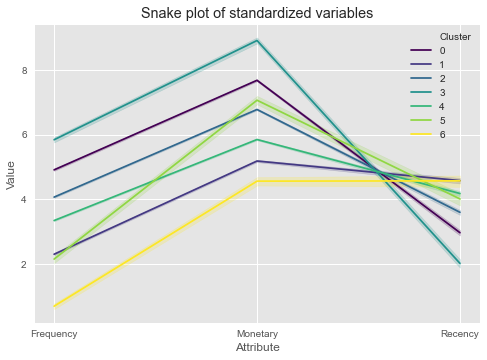

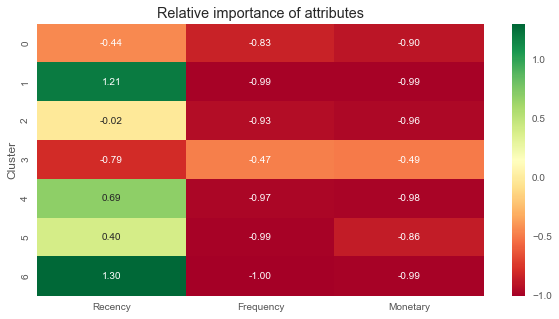

In [180]:
data_norm_k = clustering.compate_segments(rfm_4,rfm_5,'CustomerID',cluster_labels)